# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [3]:
import os # for path operations
import time #for time operations
import uuid #for generating unique id
import cv2 #for image operations

In [4]:
IMAGES_PATH = os.path.join('data','images') #we will be putting the images in data/images
number_images = 30 #number of images that we need as samples 

In [ ]:
for image_num in range(30):
    print(image_num)

In [70]:
cap = cv2.VideoCapture(0) # 0 for webcam, 1 for external camera 

#looping through the range of images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() #cap is assigned to videoCapture from cv2 -> which is an openCV function
    
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') #creating a unique name for the image, and joining it with the path
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5) #this gives a bit of time to the camera to adjust to the light

    #to break out of the loop if q is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

: 

### 1.3 Annotate Images with LabelMe

In [6]:
!labelme

2024-01-31 10:16:47,008 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\devin\.labelmerc


# 2. Review Dataset and Build Image Loading Function

1. We're gonna look through collected samples through matpotlib
2. We will be partitioning to training, testintg and validating partitions

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth -> tensorflow always take maximum vram, to avoid that we set it to limited growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU') #if it does not return an error, it means that the GPU is ready for deep learning

[]

### 2.3 Load Image into TF Data Pipeline

In [26]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [7]:
print(images)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [8]:
images.as_numpy_iterator().next()

b'data\\images\\5eba6d3c-c0db-11ee-a3cc-70a6ccf719bb.jpg'

In [23]:
def load_image(x): #returns the image in the form of a tensor
    byte_img = tf.io.read_file(x) #taking the file path
    img = tf.io.decode_jpeg(byte_img) #decoding the image
    return img

In [27]:
images = images.map(load_image) 

In [28]:
print(images)

<_MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>


In [29]:
images.as_numpy_iterator().next()

array([[[181, 194, 210],
        [185, 198, 214],
        [188, 197, 212],
        ...,
        [142, 138, 126],
        [150, 143, 133],
        [149, 142, 132]],

       [[184, 197, 213],
        [186, 198, 212],
        [187, 196, 211],
        ...,
        [143, 139, 128],
        [147, 143, 132],
        [147, 140, 130]],

       [[191, 203, 217],
        [188, 200, 214],
        [187, 196, 211],
        ...,
        [136, 133, 124],
        [137, 133, 124],
        [134, 130, 121]],

       ...,

       [[220, 242, 255],
        [215, 237, 250],
        [219, 241, 255],
        ...,
        [ 20,  19,  27],
        [ 21,  20,  28],
        [ 24,  23,  31]],

       [[223, 242, 255],
        [218, 237, 252],
        [218, 237, 254],
        ...,
        [ 20,  18,  29],
        [ 20,  18,  29],
        [ 22,  20,  31]],

       [[222, 241, 255],
        [217, 236, 253],
        [214, 233, 250],
        ...,
        [ 20,  18,  29],
        [ 20,  18,  29],
        [ 23,  21,  32]]

In [30]:
type(images) #type of images should be a tensorflow data pipeline

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [13]:

image_generator = images.batch(4).as_numpy_iterator() #basically returns a batch of 4 images in one batch

In [14]:
plot_images = image_generator.next()

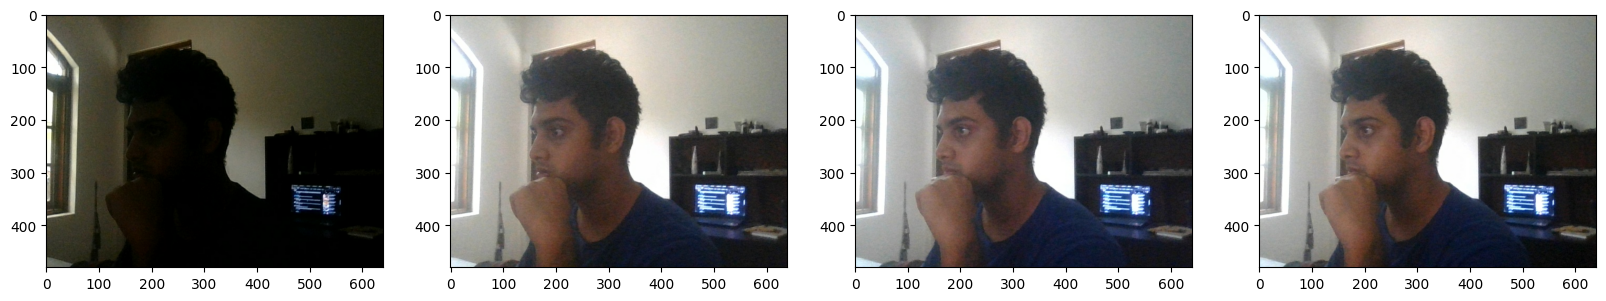

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [63]:
120*.7 # 63 to train

84.0

In [64]:
120*.15 # 18 and 18 to test and val

18.0

In [66]:
(18*2) + 84

120

### 3.2 Move the Matching Labels

In [7]:
#This will move the associated labeled json files to the respective folders, since we manually moved the raw data to the respective environment folders

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [6]:
import albumentations as alb

In [15]:

#augments the images in different ways, like horizontal flip, vertical flip, random crop, random brightness, random contrast, random gamma, random RGB shift
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [16]:
img = cv2.imread(os.path.join('data','train', 'images','59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.jpg'))
#this is just to load one image and test it out 

In [15]:
with open(os.path.join('data', 'train', 'labels', '59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.json'), 'r') as f:
    label = json.load(f)
    #this is to load the json file associated with the image

In [16]:
print(label)

{'version': '5.4.1', 'flags': {}, 'shapes': [{'label': 'face', 'points': [[148.7878787878788, 94.54545454545453], [330.10101010101016, 315.25252525252523]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}], 'imagePath': '..\\images\\59c65ea2-bf75-11ee-ab8f-70a6ccf719bb.jpg', 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU

In [17]:
label['shapes'][0]['points']

[[148.7878787878788, 94.54545454545453],
 [330.10101010101016, 315.25252525252523]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [10]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [11]:
coords

[136.16161616161617, 89.49494949494948, 334.1414141414142, 340.50505050505046]

In [12]:

#we a re dividing by 640 and 480 because the image is of that size, and we want the coordinates to be in the range of 0 to 1
coords = list(np.divide(coords, [640,480,640,480]))

In [13]:
coords

[0.21275252525252525,
 0.18644781144781142,
 0.5220959595959597,
 0.7093855218855218]

### 4.4 Apply Augmentations and View Results

In [17]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [18]:
augmented['bboxes'][0][2:]

(0.9951964085297419, 0.7255667789001121)

In [19]:
augmented['bboxes']

[(0.5552413019079685,
  0.16776655443322105,
  0.9951964085297419,
  0.7255667789001121)]

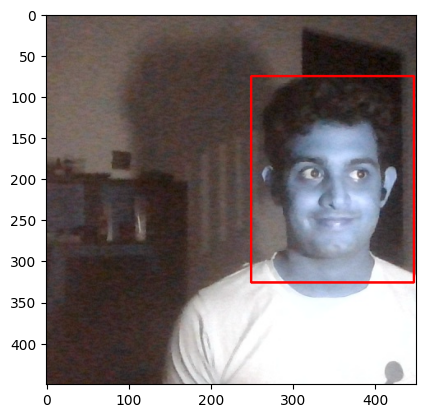

In [20]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [21]:
for partition in ['train','test','val']: #looping within the partitions
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001] #if some images that do not have any faces, we will set the default coordinate as this
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: #like 4th section, we are doing it for 60 images
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [31]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [32]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.17267157, 0.17169118, 0.24227941],
        [0.1601103 , 0.17022058, 0.22757353],
        [0.12401961, 0.15      , 0.19215687],
        ...,
        [0.08106618, 0.09675245, 0.10067402],
        [0.10392157, 0.1122549 , 0.11862745],
        [0.078125  , 0.08737745, 0.09865196]],

       [[0.16207108, 0.17009804, 0.22892156],
        [0.1348652 , 0.15159313, 0.1985294 ],
        [0.15183823, 0.17585784, 0.22193627],
        ...,
        [0.10183824, 0.10575981, 0.12144608],
        [0.07671569, 0.09583333, 0.10759804],
        [0.04852941, 0.09852941, 0.10165441]],

       [[0.15980393, 0.17156863, 0.23039216],
        [0.16078432, 0.17794117, 0.21973039],
        [0.13976716, 0.17022058, 0.18486519],
        ...,
        [0.09497549, 0.09889706, 0.11458334],
        [0.08584559, 0.10845588, 0.10906862],
        [0.02984069, 0.08511029, 0.07463235]],

       ...,

       [[0.06372549, 0.0754902 , 0.09509804],
        [0.05196078, 0.07156863, 0.0872549 ],
        [0.06617647, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [35]:
def load_labels(label_path): #this is same as load_images
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f) #loading the json file here 
        
    return [label['class']], label['bbox'] #returns two arrays, class and bounding box. Class is the name of the box

### 6.2 Load Labels to Tensorflow Dataset

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)



In [38]:
test_labels.as_numpy_iterator().next()

b'aug_data\\test\\labels\\5c8d026a-bf75-11ee-af20-70a6ccf719bb.0.json'

In [39]:
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)

#there is a bit of a mix up here which is done by the py_function
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2976, 0.16  , 0.7017, 0.674 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [42]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [43]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [46]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3062 , 0.2793 , 0.69   , 0.7676 ],
        [0.2935 , 0.1342 , 0.785  , 0.7964 ],
        [0.     , 0.1254 , 0.3762 , 0.83   ],
        [0.08057, 0.2915 , 0.4937 , 0.8247 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.972  , 0.272  , 1.     , 0.86   ],
        [0.4363 , 0.3184 , 0.817  , 0.81   ]], dtype=float16))

### 7.3 View Images and Annotations

In [47]:
data_samples = train.as_numpy_iterator()

In [48]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


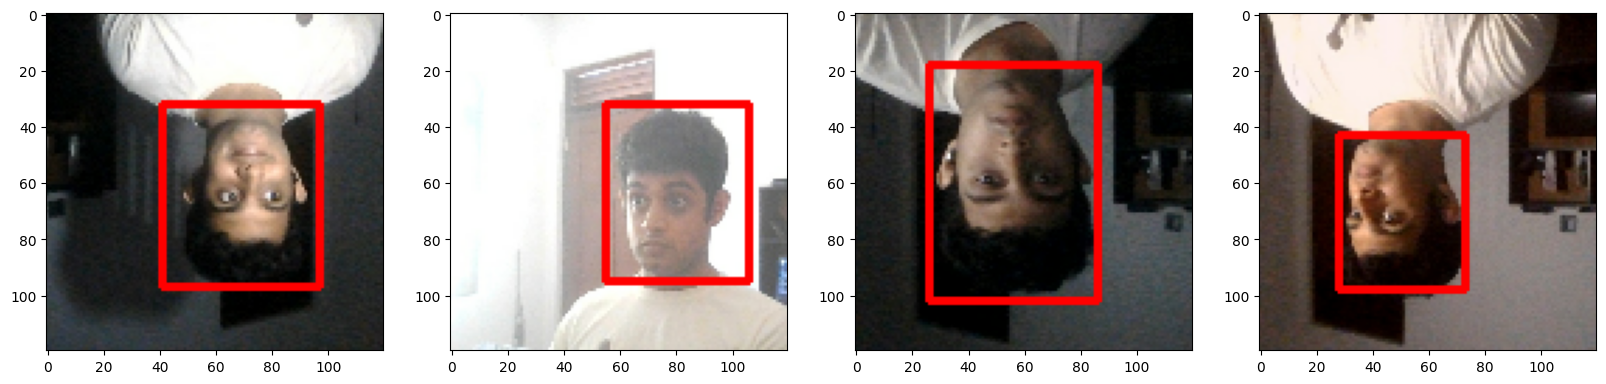

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    #here in the declaration of the sample_image, it had to be in an np.array
    sample_image = np.array(res[0][idx])
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [51]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

### 8.3 Build instance of Network

In [53]:

def build_model(): 
    
    #when youre creating a neural network, we need to create input layers
    input_layer = Input(shape=(120,120,3)) #120x120x3 pixel input
    
    #we are using the VGG16 model here, and we are using the input layer as the input
    vgg = VGG16(include_top=False)(input_layer)

    #we've mentioned the activation functions here as well
    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [56]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1697 , 0.2241 , 0.54   , 0.7134 ],
        [0.506  , 0.1787 , 1.     , 0.8833 ],
        [0.08124, 0.2416 , 0.576  , 0.86   ],
        [0.1187 , 0.1714 , 0.632  , 0.8267 ],
        [0.2915 , 0.1702 , 0.7046 , 0.7427 ],
        [0.     , 0.2595 , 0.3687 , 0.832  ],
        [0.547  , 0.2269 , 0.9165 , 0.6885 ],
        [0.3843 , 0.2563 , 0.8096 , 0.7827 ]], dtype=float16))

### 8.4 Test out Neural Network

In [55]:
facetracker = build_model()

In [57]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [58]:
X, y = train.as_numpy_iterator().next() #X will be images, y will be labels

In [59]:
X.shape

(8, 120, 120, 3)

In [60]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 576ms/step


In [61]:
classes, coords

(array([[0.5362398 ],
        [0.413206  ],
        [0.55650085],
        [0.44063234],
        [0.4147659 ],
        [0.52445877],
        [0.49500623],
        [0.5633568 ]], dtype=float32),
 array([[0.57033736, 0.4832402 , 0.5667308 , 0.6397605 ],
        [0.57310086, 0.37102774, 0.5975566 , 0.5376435 ],
        [0.5785403 , 0.46450308, 0.5035664 , 0.63122183],
        [0.5759034 , 0.4738692 , 0.5886698 , 0.66440177],
        [0.5478294 , 0.4284267 , 0.5598949 , 0.59520406],
        [0.59872574, 0.39590114, 0.6602862 , 0.63340485],
        [0.56686187, 0.4362214 , 0.46156922, 0.6058978 ],
        [0.5847727 , 0.37646106, 0.6180196 , 0.5697937 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [62]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [65]:

#had to make this legacy since, decay parameter is no longer available, but look for the valid change asap
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay) 

### 9.2 Create Localization Loss and Classification Loss

In [66]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [67]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [68]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.276258>

In [69]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7462332>

In [70]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.276258>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [71]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [72]:
model = FaceTracker(facetracker)

In [73]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [74]:
logdir='logs'

In [75]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


630/630 [==============================] - 417s 648ms/step - total_loss: 0.0808 - class_loss: 0.0290 - regress_loss: 0.0663 - val_total_loss: 1.3686 - val_class_loss: 0.9767 - val_regress_loss: 0.8803
Epoch 2/10
630/630 [==============================] - 430s 678ms/step - total_loss: 0.0622 - class_loss: 0.0213 - regress_loss: 0.0516 - val_total_loss: 0.0127 - val_class_loss: 0.0012 - val_regress_loss: 0.0121
Epoch 3/10
630/630 [==============================] - 431s 680ms/step - total_loss: 0.0616 - class_loss: 0.0246 - regress_loss: 0.0493 - val_total_loss: 2.1672 - val_class_loss: 0.9661 - val_regress_loss: 1.6842
Epoch 4/10
630/630 [==============================] - 426s 671ms/step - total_loss: 0.0420 - class_loss: 0.0151 - regress_loss: 0.0345 - val_total_loss: 0.0180 - val_class_loss: 6.6903e-04 - val_regress_loss: 0.0177
Epoch 5/10
630/630 [==============================] - 420s 663ms/step - total_loss: 0.0124 - class_loss: 0.0028 - regress_loss: 0.0110 - val_total_loss: 4.3235

### 10.3 Plot Performance

In [78]:
hist.history

{'total_loss': [0.03506488353013992,
  0.010094434022903442,
  0.3998013734817505,
  0.013038001023232937,
  0.004718564450740814,
  0.006773684173822403,
  0.0039262427017092705,
  0.004896158818155527,
  0.006761572323739529,
  0.004360203165560961],
 'class_loss': [0.006333465687930584,
  0.0016454587457701564,
  0.1605003923177719,
  0.0005155859980732203,
  4.4466803956311196e-05,
  4.6695560740772635e-05,
  2.949799454654567e-05,
  0.000892040494363755,
  8.11423160484992e-05,
  6.4221749198623e-05],
 'regress_loss': [0.03189815208315849,
  0.009271704591810703,
  0.31955116987228394,
  0.012780208140611649,
  0.004696330986917019,
  0.00675033638253808,
  0.0039114938117563725,
  0.004450138658285141,
  0.0067210011184215546,
  0.004328092094510794],
 'val_total_loss': [1.3685967922210693,
  0.01272935513406992,
  2.167222499847412,
  0.01800508238375187,
  4.323536396026611,
  0.019521772861480713,
  1.4129226207733154,
  0.003658788511529565,
  0.07492005825042725,
  0.0679352

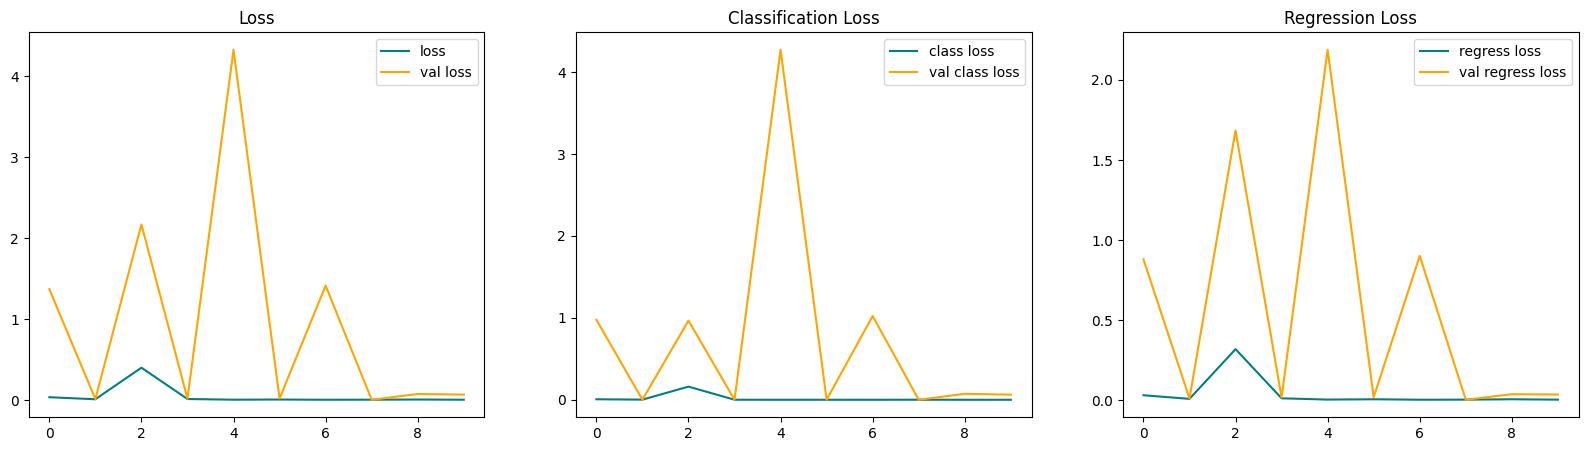

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
test_sample = test_data.next()

In [82]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 227ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


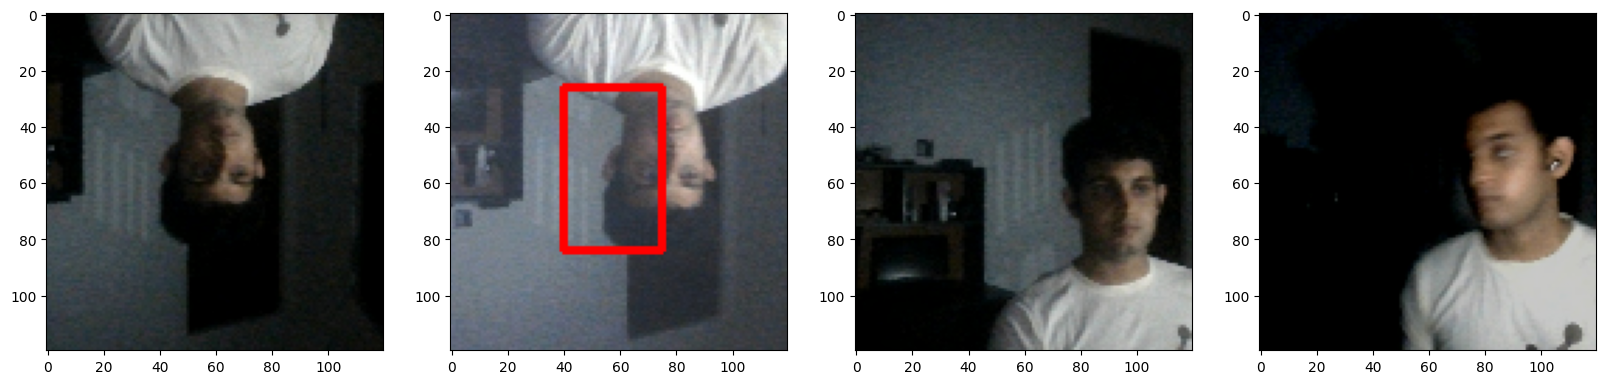

In [84]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Create a copy of the NumPy array
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

plt.show()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


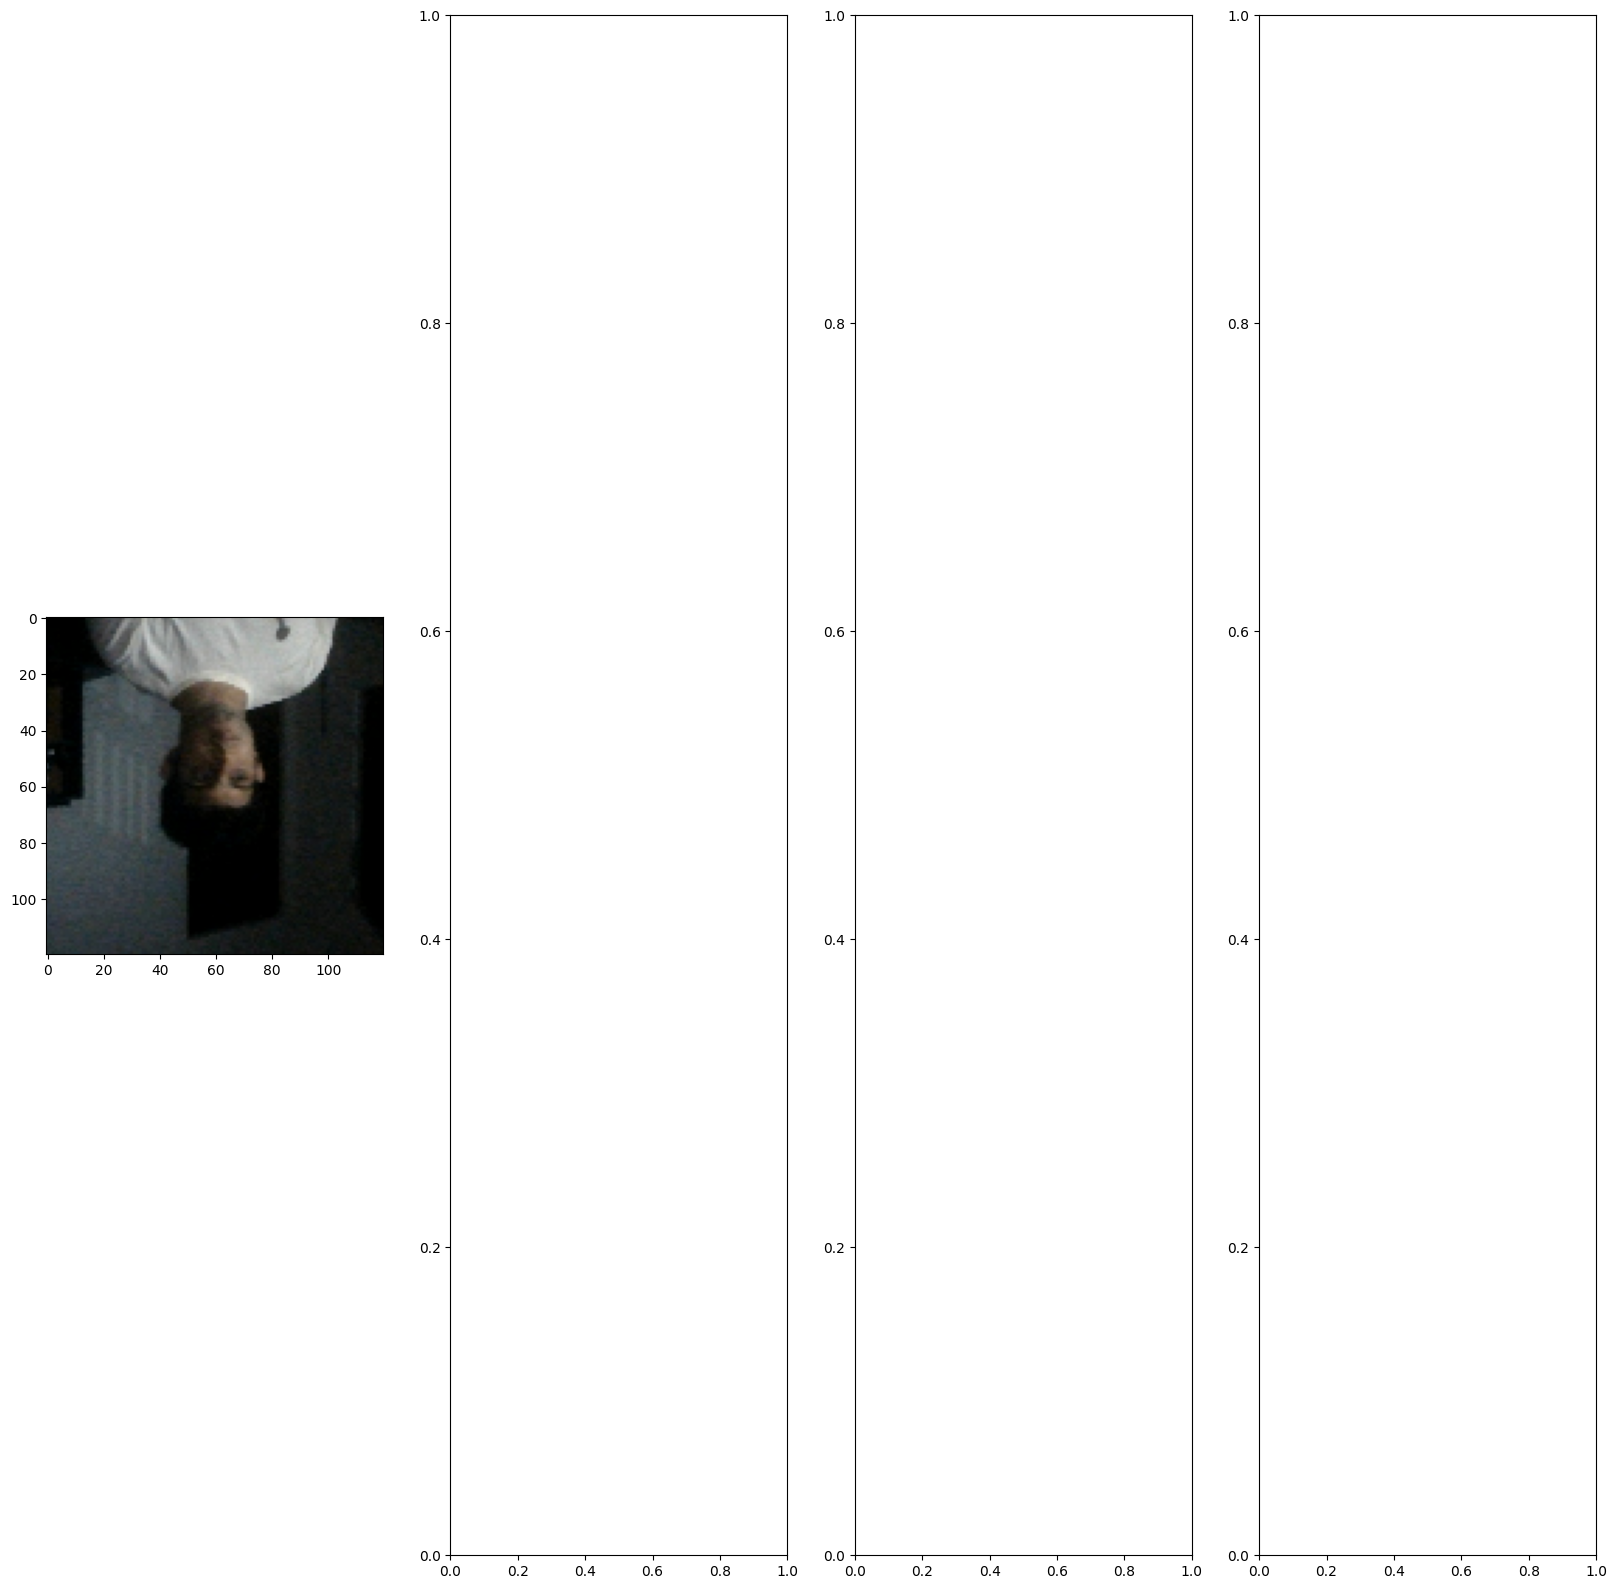

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [85]:
from tensorflow.keras.models import load_model

In [86]:
facetracker.save('facetracker.h5')

e:\Projects\AI Projects\FaceDetection\faceDetection\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [89]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 79ms/step


KeyboardInterrupt: 

: 